In [ ]:
# Imports and setup
from pathlib import Path
import numpy as np
from icwaves.evaluation.evaluation import load_classifier, eval_classifier_per_subject_brain_F1
from icwaves.evaluation.config import EvalConfig
from icwaves.data.loading import get_feature_extractor, load_data_bundles
from icwaves.viz import plot_line_with_error_area
from icwaves.evaluation.iclabel import calculate_iclabel_f1_scores


In [ ]:
validation_times = np.r_[
    [9.0, 19.5, 30.0, 39.0, 49.5, 60],
    np.arange(2 * 60, 5 * 60 + 1, 60),
    np.arange(5 * 60, 5 * 60 + 1, 60),
    np.arange(10 * 60, 50 * 60 + 1, 5 * 60),
].astype(float)
root = Path().absolute().parent
mean_std_df = {}
for eval_dataset in ["cue", "emotion_study"]:
    mean_std_df[eval_dataset] = {}
    for feature_extractor_str in ["bowav", "psd_autocorr", "bowav_psd_autocorr"]:
        mean_std_df[eval_dataset][feature_extractor_str] = {}
        # Configuration
        config = EvalConfig(
            eval_dataset=eval_dataset,
            feature_extractor=feature_extractor_str,
            classifier_type="random_forest",
            validation_segment_length=300,
            root=root,
        )
        # Load data
        print(f"Getting data from {eval_dataset}, and building feature extractor for {feature_extractor_str}...")
        data_bundles = load_data_bundles(config)
        feature_extractor = get_feature_extractor(feature_extractor_str, data_bundles)
        feature_extractor = {feature_extractor_str: feature_extractor}
        for classifier_type in ["random_forest"]:  # ["random_forest", "logistic"]:
            config.classifier_type = classifier_type
            mean_std_df[eval_dataset][feature_extractor_str][classifier_type] = {}
            for validation_segment_len in [-1.0]:#  [300, -1]:
                config.validation_segment_length = validation_segment_len
                print(f"Validation segment length: {validation_segment_len} | classifier type: {classifier_type}")
                # Load classifier
                clf, best_params = load_classifier(config.path_to_classifier)
                clf = {feature_extractor_str: clf}

                # TODO: make this cleaner
                # for 'psd_autocorr', the training segment length is in samples. Since the sampling rate
                # for 'emotion' and 'cue' are 256 Hz and 500 Hz, we need to convert that length.
                if eval_dataset == "cue" and "psd_autocorr" in best_params["training_segment_length"]:
                    best_params["training_segment_length"]["psd_autocorr"] = int(best_params["training_segment_length"]["psd_autocorr"] / 256 * 500)

                # Evaluate
                print("Computing F1 score...")
                agg_method = {feature_extractor_str: best_params["input_or_output_aggregation_method"]}
                mean_std_df[eval_dataset][feature_extractor_str][classifier_type][validation_segment_len] = eval_classifier_per_subject_brain_F1(
                    config,
                    clf,
                    feature_extractor,
                    validation_times,
                    data_bundles,
                    agg_method,
                    best_params["training_segment_length"],
                )

Getting data from cue, and building feature extractor for bowav...
Validation segment length: -1.0 | classifier type: random_forest
Computing F1 score...


 55%|█████▌    | 132/240 [00:06<00:05, 19.43it/s]


Getting data from cue, and building feature extractor for psd_autocorr...


12it [00:25,  2.15s/it]


Validation segment length: -1.0 | classifier type: random_forest
Computing F1 score...


 70%|███████   | 168/240 [15:10<06:30,  5.42s/it]


Getting data from cue, and building feature extractor for bowav_psd_autocorr...
Validation segment length: -1.0 | classifier type: random_forest
Computing F1 score...


 55%|█████▌    | 132/240 [16:35<13:34,  7.54s/it]


Getting data from emotion_study, and building feature extractor for bowav...


7it [00:40,  5.86s/it]


[{'architecture': 'armv8',
  'filepath': '/Users/gcarlmen/personal_repos/ICWaves/.venv/lib/python3.10/site-packages/numpy/.dylibs/libopenblas64_.0.dylib',
  'internal_api': 'openblas',
  'num_threads': 10,
  'prefix': 'libopenblas',
  'threading_layer': 'pthreads',
  'user_api': 'blas',
  'version': '0.3.23.dev'},
 {'filepath': '/Users/gcarlmen/personal_repos/ICWaves/.venv/lib/python3.10/site-packages/sklearn/.dylibs/libomp.dylib',
  'internal_api': 'openmp',
  'num_threads': 10,
  'prefix': 'libomp',
  'user_api': 'openmp',
  'version': None},
 {'architecture': 'armv8',
  'filepath': '/Users/gcarlmen/personal_repos/ICWaves/.venv/lib/python3.10/site-packages/scipy/.dylibs/libopenblas.0.dylib',
  'internal_api': 'openblas',
  'num_threads': 10,
  'prefix': 'libopenblas',
  'threading_layer': 'pthreads',
  'user_api': 'blas',
  'version': '0.3.21.dev'}]


100%|██████████| 1469/1469 [1:20:41<00:00,  3.30s/it]


Validation segment length: -1.0 | classifier type: random_forest
Computing F1 score...
Loading cached results from /Users/gcarlmen/personal_repos/ICWaves/results/emotion_study/evaluation/eval_brain_f1_random_forest_bowav_none.csv
Getting data from emotion_study, and building feature extractor for psd_autocorr...


7it [00:40,  5.85s/it]


Validation segment length: -1.0 | classifier type: random_forest
Computing F1 score...
Loading cached results from /Users/gcarlmen/personal_repos/ICWaves/results/emotion_study/evaluation/eval_brain_f1_random_forest_psd_autocorr_none.csv
Getting data from emotion_study, and building feature extractor for bowav_psd_autocorr...
Validation segment length: -1.0 | classifier type: random_forest
Computing F1 score...
Loading cached results from /Users/gcarlmen/personal_repos/ICWaves/results/emotion_study/evaluation/eval_brain_f1_random_forest_bowav_psd_autocorr_none.csv


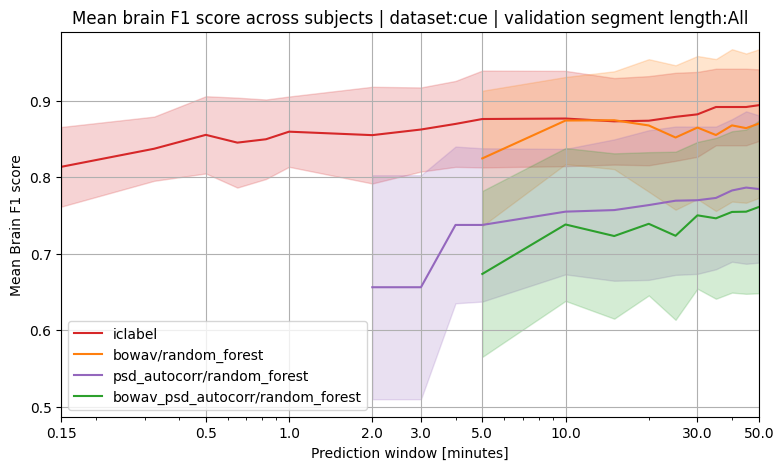

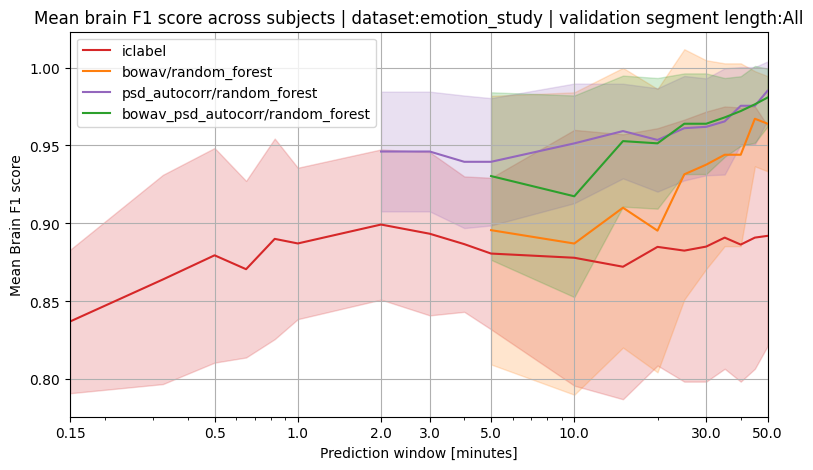

In [3]:
import matplotlib.pyplot as plt
global_x_ticks = np.array([0.15, 0.5, 1, 2, 3, 5, 10, 30, 50])
# colors = {"bowav/logistic": "blue", "psd_autocorr/logistic": "green", "bowav/random_forest": "orange", "psd_autocorr/random_forest": "purple"}
colors = {"bowav_psd_autocorr/random_forest": "green", "bowav/random_forest": "orange", "psd_autocorr/random_forest": "purple"}
val_seg_len_map = {-1: "All", 300: "5-minutes"}
# The *.mat files with the ICLabel labels were manually created for the following prediction times
    #     9.0,    19.5,    30.0,    39.0,    49.5
    #    60.0,   120.0,   180.0,   240.0,   300.0
    #   300.0,   600.0,   900.0,  1200.0,  1500.0
    #  1800.0,  2100.0,  2400.0,  2700.0,  3000.0
validation_times_ = 1.5 * (validation_times // 1.5)
for eval_dataset in ["cue", "emotion_study"]:
    # For ICLabel, the values for feature_extractor, classifier_type, train_dataset, and validation_segment_length
    # don't matter, as they are not used.
    config = EvalConfig(
        eval_dataset=eval_dataset,
        feature_extractor="bowav",
        classifier_type="logistic",
        validation_segment_length=-1,
        root=root,
    )
    iclabel_df = calculate_iclabel_f1_scores(config, validation_times_)
    iclabel_df = iclabel_df.rename(
            columns={
                "Brain F1 score - iclabel": "iclabel",
            }
        )

    for validation_segment_len in [-1]:  #  [-1, 300]:
        fig, ax = plt.subplots(figsize=(9, 5))
        ax = plot_line_with_error_area(
            ax,
            iclabel_df,
            "Prediction window [minutes]",
            "iclabel",
            "StdDev - iclabel",
            color="red"
        )
        for classifier_type in ["random_forest"]:  # ["random_forest", "logistic"]:
            for feature_extractor_str in ["bowav", "psd_autocorr", "bowav_psd_autocorr"]:
                df = mean_std_df[eval_dataset][feature_extractor_str][classifier_type][validation_segment_len]
                # rename columns to also include the classifier type (e.g., "Brain F1 score - bowav" -> "Brain F1 score - bowav-logistic")
                df = df.rename(
                    columns={
                        "Brain F1 score - " + feature_extractor_str: f"{feature_extractor_str}/{classifier_type}",
                        "StdDev - " + feature_extractor_str: f"StdDev - {feature_extractor_str}/{classifier_type}"
                    }
                )
                ax = plot_line_with_error_area(
                    ax,
                    df,
                    "Prediction window [minutes]",
                    f"{feature_extractor_str}/{classifier_type}",
                    f"StdDev - {feature_extractor_str}/{classifier_type}",
                    color=colors[f"{feature_extractor_str}/{classifier_type}"]
                )

        ax.set_xscale("log")
        ax.set_xticks(global_x_ticks, labels=global_x_ticks)
        ax.set_xlim(global_x_ticks[0], 50)
        ax.set_xlabel("Prediction window [minutes]")
        ax.set_ylabel("Mean Brain F1 score")
        ax.set_title(f"Mean brain F1 score across subjects | dataset:{eval_dataset} | validation segment length:{val_seg_len_map[validation_segment_len]}")
        ax.legend()
        ax.grid(True)